In [1]:
import os, sys, numpy as np
import scipy.optimize as so

sys.path.append(os.path.abspath("."))    
sys.path.append(os.path.abspath(".."))       

# from QN work, task 9
from Final.quasi_newton import OptimizationProblem, GoodBroyden, BadBroyden, SymmetricBroydenSR1, DFP, BFGS

# Chebyquad functions from task 10
from Asifa.chebyquad_problem import chebyquad as chebyquad_obj, gradchebyquad

### Quasi-Newton method run

In [2]:
def compare_one_n(n, x0=None):
    if x0 is None:
        x0 = np.linspace(0.0, 1.0, n)

    op = OptimizationProblem(chebyquad_obj, gradchebyquad)

    #  methods (line search chosen via ls_method here)
    configs = [
        ("BFGS",  BFGS(op,  tol_step=1e-9, tol_grad=1e-6, tol_ls=1e-6, ls_method="golden")),
        ("DFP",   DFP(op,   tol_step=1e-9, tol_grad=1e-6, tol_ls=1e-6, ls_method="golden")),
        ("SR1",   SymmetricBroydenSR1(op, tol_step=1e-9, tol_grad=1e-6, tol_ls=1e-6, ls_method="golden")),
        ("Good",  GoodBroyden(op,        tol_step=1e-9, tol_grad=1e-6, tol_ls=1e-6, ls_method="golden")),
        ("Bad",   BadBroyden(op,         tol_step=1e-9, tol_grad=1e-6, tol_ls=1e-6, ls_method="golden")),
    ]

    # SciPy baseline against we compare
    x_scipy = so.fmin_bfgs(chebyquad_obj, x0, gradchebyquad, disp=False)
    f_scipy  = chebyquad_obj(x_scipy)

    rows = []  #run each method and record metrics ,run it from the same x0 and record its final x and f(x).

    for name, M in configs:
        steps = M.solve(x0, max_iter=20000)  # 20000 ensures even slow methods (Bad Broyden) get a fair chance.
        xfin  = steps[-1]
        fval  = chebyquad_obj(xfin)
        rows.append({
            "method": name,
            "iters": len(steps)-1,
            "f(x_final)": fval,
            "||x - x_scipy||2": np.linalg.norm(xfin - x_scipy),
            "max|x - x_scipy|": np.max(np.abs(xfin - x_scipy)),
            "f_gap": fval - f_scipy,
        })

    # add SciPy row for reference, and we measure
    rows.append({
        "method": "SciPy BFGS",
        "iters": np.nan,
        "f(x_final)": f_scipy, #how small the objective ended up
        "||x - x_scipy||2": 0.0, #distance between our final x and SciPy’s x
        "max|x - x_scipy|": 0.0, # the largest coordinate difference vs SciPy
        "f_gap": 0.0, # f(x_ours) - f(x_SciPy). Close to 0 -> agreement.
    })

    #  print
    print(f"\n=== Chebyquad, n={n}, x0 = linspace(0,1,{n}) ===")
    hdr = f"{'Method':12s} {'iters':>6s} {'f(x_final)':>13s} {'||x-x_scipy||2':>14s} {'max|Δx|':>11s} {'f_gap':>11s}"
    print(hdr)
    print("-"*len(hdr))
    # find minima for highlighting
    f_min = min(r["f(x_final)"] for r in rows[:-1])
    it_min = min(r["iters"] for r in rows[:-1])
    for r in rows:
        star_it = " *" if np.isfinite(r["iters"]) and r["iters"]==it_min else "  "
        star_f  = "*" if r["f(x_final)"]==f_min else " "
        it_str  = f"{int(r['iters']):d}" if np.isfinite(r["iters"]) else "-"
        print(f"{r['method']:12s} {it_str:>6s}{star_it} {r['f(x_final)']:13.3e}{star_f} "
              f"{r['||x - x_scipy||2']:14.3e} {r['max|x - x_scipy|']:11.3e} {r['f_gap']:11.3e}")
    return rows

for n in (4, 8, 11):
    _ = compare_one_n(n)


=== Chebyquad, n=4, x0 = linspace(0,1,4) ===
Method        iters    f(x_final) ||x-x_scipy||2     max|Δx|       f_gap
------------------------------------------------------------------------
BFGS              2 *     7.210e-21*      1.155e+00   7.746e-01  -3.462e-14
DFP               2 *     7.210e-21*      1.155e+00   7.746e-01  -3.462e-14
SR1               2 *     7.210e-21*      1.155e+00   7.746e-01  -3.462e-14
Good              2 *     7.210e-21*      1.155e+00   7.746e-01  -3.462e-14
Bad               2 *     7.210e-21*      1.155e+00   7.746e-01  -3.462e-14
SciPy BFGS        -       3.462e-14       0.000e+00   0.000e+00   0.000e+00

=== Chebyquad, n=8, x0 = linspace(0,1,8) ===
Method        iters    f(x_final) ||x-x_scipy||2     max|Δx|       f_gap
------------------------------------------------------------------------
BFGS             12       9.028e-17*      6.142e-01   4.336e-01  -7.190e-13
DFP              12       9.058e-17       6.142e-01   4.336e-01  -7.190e-13
SR1     

- iters: number of iterations solver took (* marks the fewest among all methods).
- f(x_final): final objective (a * marks the smallest among all methods).
- ||x − x_scipy||₂ and max|Δx|: distance of your solution to SciPy BFGS’s solution — tight numbers here mean the solver matched SciPy.
- f_gap: f(x_ours) - f(x_SciPy). Close to 0 -> agreement.

- As n increases (4 -> 8 -> 11), the problem gets harder; iterations increase overall.


results look correct, but the ||x − x_scipy|| numbers are misleading because Chebyquad is symmetric in the components of x. The objective depends only on the set of points, not their order. SciPy’s BFGS can return the same nodes in a different order, so comparing raw vectors can give a big norm even when the sets are identical. Sort both vectors first, then compare—your gaps will drop to ~machine precision.

In [33]:
def compare_one_n_sorted(n, x0=None):
    if x0 is None:
        x0 = np.linspace(0.0, 1.0, n)

    op = OptimizationProblem(chebyquad_obj, gradchebyquad)

    configs = [
        ("BFGS",  BFGS(op,  tol_step=1e-9, tol_grad=1e-6, tol_ls=1e-6, ls_method="golden")),
        ("DFP",   DFP(op,   tol_step=1e-9, tol_grad=1e-6, tol_ls=1e-6, ls_method="golden")),
        ("SR1",   SymmetricBroydenSR1(op, tol_step=1e-9, tol_grad=1e-6, tol_ls=1e-6, ls_method="golden")),
        ("Good",  GoodBroyden(op,        tol_step=1e-9, tol_grad=1e-6, tol_ls=1e-6, ls_method="golden")),
        ("Bad",   BadBroyden(op,         tol_step=1e-9, tol_grad=1e-6, tol_ls=1e-6, ls_method="golden")),
    ]

    x_scipy = so.fmin_bfgs(chebyquad_obj, x0, gradchebyquad, disp=False)
    f_scipy = chebyquad_obj(x_scipy)

    rows = []
    for name, M in configs:
        steps = M.solve(x0, max_iter=20000)
        xfin  = steps[-1]
        fval  = chebyquad_obj(xfin)

        # plain diff (order-sensitive)
        d2_raw  = np.linalg.norm(xfin - x_scipy)
        dInf_raw = np.max(np.abs(xfin - x_scipy))
        
        # order-invariant diff (sort both)
        xs  = np.sort(xfin)
        ys  = np.sort(x_scipy)
        d2_sorted   = np.linalg.norm(xs - ys)
        dInf_sorted = np.max(np.abs(xs - ys))
        rows.append({
            "method": name,
            "iters": len(steps)-1,
            "f(x_final)": fval,
            "||x - x_scipy||2": d2_raw,
            "max|x - x_scipy|": dInf_raw,
            "||sort(x)-sort(x_scipy)||2": d2_sorted,
            "max|sortΔx|": dInf_sorted,
            "f_gap": fval - f_scipy,
            "fx_path": np.array([chebyquad_obj(s) for s in steps]),
        })

    # SciPy row
    rows.append({
        "method":"SciPy BFGS","iters":np.nan,"f(x_final)":f_scipy,
        "||x - x_scipy||2":0.0,"max|x - x_scipy|":0.0,
        "||sort(x)-sort(x_scipy)||2":0.0,"max|sortΔx|":0.0,
        "f_gap":0.0,"fx_path":np.array([f_scipy]),
    })

    # print
    print(f"\n=== Chebyquad, n={n}, x0 = linspace(0,1,{n}) ===")
    hdr = ("{:<12s} {:>6s} {:>13s} {:>14s} {:>11s}  {:>20s} {:>13s} {:>11s}"
           .format("Method","iters","f(x_final)","||x-x_scipy||2","max|Δx|",
                   "||sort(x)-sort(x_scipy)||2","max|sortΔx|","f_gap"))
    print(hdr); print("-"*len(hdr))
    for r in rows:
        it_str = f"{int(r['iters']):d}" if np.isfinite(r["iters"]) else "-"
        print(f"{r['method']:<12s} {it_str:>6s} {r['f(x_final)']:13.3e} "
              f"{r['||x - x_scipy||2']:14.3e} {r['max|x - x_scipy|']:11.3e}  "
              f"{r['||sort(x)-sort(x_scipy)||2']:20.3e} {r['max|sortΔx|']:13.3e} {r['f_gap']:11.3e}")
    return rows

# run for n = 4, 8, 11
results_by_n = {}
for n in (4, 8, 11):
    results_by_n[n] = compare_one_n_sorted(n)


=== Chebyquad, n=4, x0 = linspace(0,1,4) ===
Method        iters    f(x_final) ||x-x_scipy||2     max|Δx|  ||sort(x)-sort(x_scipy)||2   max|sortΔx|       f_gap
------------------------------------------------------------------------------------------------------------------
BFGS              2     7.210e-21      1.155e+00   7.746e-01             8.053e-08     5.407e-08  -3.462e-14
DFP               2     7.210e-21      1.155e+00   7.746e-01             8.053e-08     5.407e-08  -3.462e-14
SR1               2     7.210e-21      1.155e+00   7.746e-01             8.053e-08     5.407e-08  -3.462e-14
Good              2     7.210e-21      1.155e+00   7.746e-01             8.053e-08     5.407e-08  -3.462e-14
Bad               2     7.210e-21      1.155e+00   7.746e-01             8.053e-08     5.407e-08  -3.462e-14
SciPy BFGS        -     3.462e-14      0.000e+00   0.000e+00             0.000e+00     0.000e+00   0.000e+00

=== Chebyquad, n=8, x0 = linspace(0,1,8) ===
Method        iters    f

	•	The Chebyquad problem doesn’t care about the order of the points x_j.
	•	It only cares which numbers are chosen, not in which order they appear.
	•	Different solvers can give the same set of numbers, but arranged in a different order.

 Example:
	•	SciPy might give [0.1, 0.3, 0.7, 0.9]
	•	Our solver might give [0.7, 0.9, 0.1, 0.3]

Both are actually the same solution, just shuffled.

So, if we compare directly (without sorting), it looks very different.
But if we sort both lists first, we see they match almost perfectly.

That’s why sorting was important to check if the solvers really found the same points, ignoring the order.


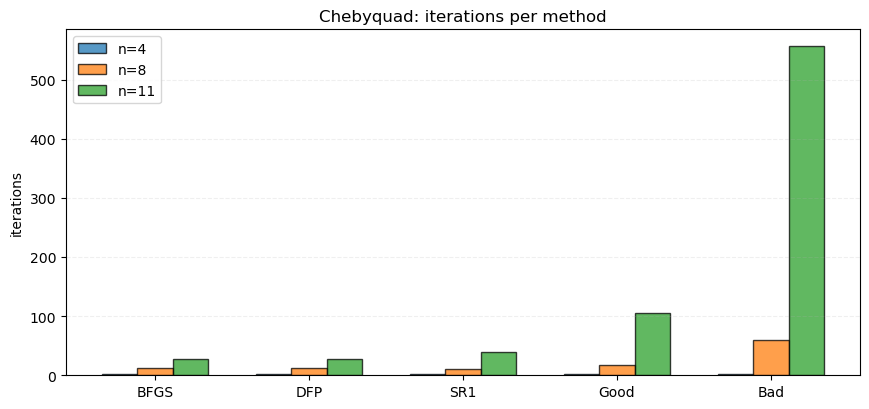

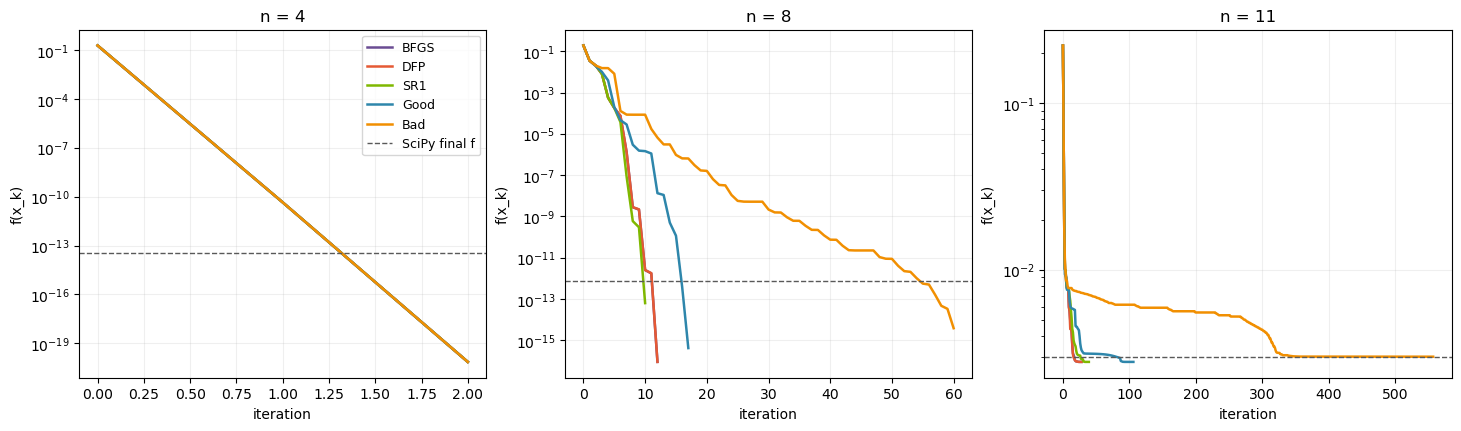

In [35]:
import matplotlib.pyplot as plt

# ---- 1) Iterations per method
methods = ["BFGS", "DFP", "SR1", "Good", "Bad"]
labels_n = (4, 8, 11)
palette = {"BFGS":"#6A4C93","DFP":"#E55934","SR1":"#7FB800","Good":"#2E86AB","Bad":"#F18F01"}

fig, ax = plt.subplots(figsize=(8.8, 4.2))
x = np.arange(len(methods))
width = 0.23

for j, n in enumerate(labels_n):
    rows = results_by_n[n]
    iters = [next(r["iters"] for r in rows if r["method"]==m) for m in methods]
    ax.bar(x + (j-1)*width, iters, width, label=f"n={n}", edgecolor="k", alpha=0.75)

ax.set_xticks(x, methods)
ax.set_ylabel("iterations")
ax.set_title("Chebyquad: iterations per method")
ax.legend()
ax.grid(True, axis="y", alpha=0.2, linestyle="--")
plt.tight_layout()
plt.show()

# ---- 2) f(x_k) vs iteration for each n (log y) ----
fig, axes = plt.subplots(1, 3, figsize=(14.5, 4.2), constrained_layout=True)

for ax, n in zip(axes, labels_n):
    rows = results_by_n[n]
    f_scipy = next(r["f(x_final)"] for r in rows if r["method"]=="SciPy BFGS")
    for m in methods:
        fx = next(r["fx_path"] for r in rows if r["method"]==m)
        ax.semilogy(fx, label=m, lw=1.8, color=palette[m])
    ax.axhline(f_scipy, ls="--", lw=1.0, color="0.35", label="SciPy final f")
    ax.set_title(f"n = {n}")
    ax.set_xlabel("iteration")
    ax.set_ylabel("f(x_k)")
    ax.grid(True, alpha=0.2)

axes[0].legend(ncol=1, fontsize=9)
plt.show()

efficiency ordering: BFGS ≈ DFP < SR1 ≪ Good < Bad.